<a href="https://colab.research.google.com/github/youkiti/oyakudachi/blob/main/%E4%BD%8F%E6%89%80%E3%83%9E%E3%83%83%E3%83%81%E3%83%B3%E3%82%B0%E6%9C%80%E9%81%A9%E5%8C%96_ver1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 学生-病院マッチング最適化ツール (Google Maps API版)

## 概要

このツールは、指定された学生リストと病院リストに基づき、各学生と病院間の公共交通機関による移動時間を考慮して、全学生の移動時間のばらつき（標準偏差）が最小になるような1対1のマッチングを計算します。移動時間の取得にはGoogle Maps Directions APIを使用しますが、APIキーがない場合はランダムな時間で代替します。

## 準備するもの

1.  **Python環境**:
    *   Google Colaboratory での実行を推奨します。
    *   必要なライブラリ: `pandas`, `numpy`, `matplotlib`, `scipy`, `aiohttp` (Colabには通常プリインストールされていますが、なければ `pip install pandas numpy matplotlib scipy aiohttp` でインストールしてください)。
2.  **Google Maps Directions APIキー (推奨)**:
    *   正確な移動時間を計算するために必要です。
    *   Google Cloud Platform で APIキーを取得し、Directions API を有効にしてください。  (https://console.cloud.google.com/welcome/new?inv=1&invt=AbtPUQ&project=aerial-acre-455110-r9)  
    *   Colabで実行する場合、Secrets (鍵のマーク)
    機能を使って `GOOGLE_MAPS_API_KEY` という名前でキーを登録してください。
    *   **注意**: APIキーがない場合、または設定に失敗した場合は、15分から120分のランダムな移動時間が使用されます。
3.  **入力データ (CSVファイル)**:
    *   以下のCSVファイルを `data_gmaps_matching` ディレクトリに配置します。
        *   `students.csv`: ヘッダー `学生ID,最寄駅` を持ち、各行に学生のIDと住所（または最寄り駅）を記載。
        *   `hospitals.csv`: ヘッダー `病院ID,最寄駅` を持ち、各行に病院のIDと住所（または最寄り駅）を記載。
    *   **注意**:
        *   学生数と病院数は同数である必要があります。
        *   初回実行時やこれらのファイルが存在しない場合、コード内に定義されたサンプル住所リスト（京都の地点30件）から自動的に `students.csv` (15件) と `hospitals.csv` (15件) が生成されます。
        *   住所はGoogle Maps APIが認識できる形式で記述してください（例: `京都府京都市中京区寺町通御池上る上本能寺前町488`）。

## 実行方法

1.  Google Colab でこのノートブック (`.ipynb` ファイル) を開きます。
2.  (推奨) Colab の Secrets 機能で `GOOGLE_MAPS_API_KEY` を設定します。
3.  ノートブックのセルを上から順に実行します。

## 処理の流れ

1.  **データ読み込み**: `data_gmaps_matching` ディレクトリから `students.csv` と `hospitals.csv` を読み込みます。ファイルが存在しない場合は、サンプルデータから生成します。  
【CSVファイルをアップロードする方法】  
 *   左側サイドバーのフォルダアイコン（ファイルエクスプローラー）をクリックします。
 *   ディレクトリを作成するために、フォルダアイコン（新しいフォルダを作成）をクリックし、「data_gmaps_matching」と入力します。
 *   作成した「data_gmaps_matching」フォルダをクリックして開きます。
 *   その上部にあるアップロードアイコン（上向き矢印）をクリックします。
 *   ファイル選択ダイアログが開くので、ローカルマシンからstudents.csvとhospitals.csvを選択して「開く」をクリックします。
2.  **移動時間計算**: 各学生と病院のペアについて、Google Maps Directions API (またはキャッシュ/ランダム値) を使用して公共交通機関での移動時間を計算し、移動時間行列を作成します。計算結果は `travel_time_cache_gmaps.json` にキャッシュされます。
3.  **マッチング最適化**: シミュレーテッドアニーリング (SA) アルゴリズムを用いて、全学生の移動時間の標準偏差が最小となるような学生と病院の組み合わせを探索します。
4.  **結果出力**: 最適化されたマッチング結果、更新された学生・病院データ、統計情報、移動時間分布グラフを `data_gmaps_matching` ディレクトリに出力します。

## 出力ファイル (data_gmaps_matching ディレクトリ内)

*   `matching_result_gmaps.csv`: 最適化された最終的なマッチング結果（学生ID, 学生住所, 病院ID, 病院住所, 計算された移動時間）。
*   `students.csv` (更新版): 各学生に割り当てられた病院IDと移動時間が追記されます。
*   `hospitals.csv` (更新版): 各病院に割り当てられた学生IDが追記されます。
*   `travel_time_cache_gmaps.json`: 計算された移動時間のキャッシュファイル。APIの呼び出し回数を減らし、再実行を高速化します。
*   `travel_time_distribution_gmaps.png`: 最適化後の割り当てにおける移動時間の分布を示すヒストグラム画像。
*   `statistics_gmaps.txt`: 最適化後の移動時間に関する統計情報（平均、標準偏差、最小値、最大値、四分位数など）。
*   **コンソール出力**: 処理の進捗状況、API呼び出しに関する情報（成功、警告、エラー）、最終的な最適化結果の統計が表示されます。

In [ ]:
from google.colab import userdata
GOOGLE_MAPS_API_KEY = userdata.get('GOOGLE_MAPS_API_KEY')

=== 学生-病院マッチング最適化 (Google Maps API版) ===

既存のデータファイルを読み込みます...
15 件の学生データを data_gmaps_matching/students.csv から読み込みました。
15 件の病院データを data_gmaps_matching/hospitals.csv から読み込みました。
既存の有効なデータを読み込みました。

処理対象: 学生 15人, 病院 15箇所
移動時間行列の構築を開始...
移動時間行列の構築完了 (0.00秒)

--- マッチング最適化開始 ---
ハンガリアンアルゴリズムで初期解を計算中...
初期解 (総時間最小): 標準偏差=10.87, 平均=28.13

シミュレーテッドアニーリング開始 (Iterations: 2000, Temp: 150.0, Rate: 0.97)
  SA進捗: 10% | 現在Std: 19.35 | 最良Std: 10.87 | 温度: 0.34
  SA進捗: 20% | 現在Std: 9.26 | 最良Std: 9.26 | 温度: 0.00
  SA進捗: 30% | 現在Std: 8.61 | 最良Std: 8.61 | 温度: 0.00
  SA進捗: 40% | 現在Std: 8.61 | 最良Std: 8.61 | 温度: 0.00
  SA進捗: 50% | 現在Std: 8.61 | 最良Std: 8.61 | 温度: 0.00
  SA進捗: 60% | 現在Std: 8.61 | 最良Std: 8.61 | 温度: 0.00
  SA進捗: 70% | 現在Std: 8.61 | 最良Std: 8.61 | 温度: 0.00
  SA進捗: 80% | 現在Std: 8.61 | 最良Std: 8.61 | 温度: 0.00
  SA進捗: 90% | 現在Std: 8.61 | 最良Std: 8.61 | 温度: 0.00
  SA進捗: 100% | 現在Std: 8.61 | 最良Std: 8.61 | 温度: 0.00
シミュレーテッドアニーリング完了 (0.11秒)

--- 最適化結果 ---
最終的な標準偏差 (最小化目標): 8.61 分
平均移動時間: 52.53 分
最小移動時間: 41.0

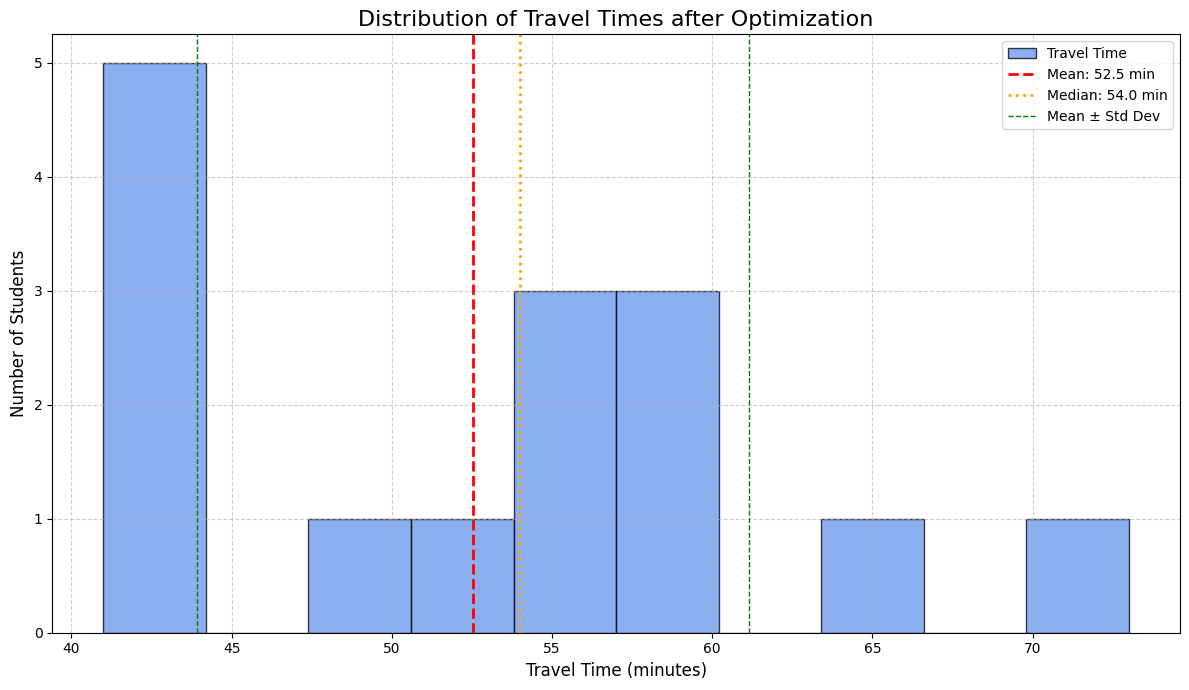

In [ ]:
# --- 必要ライブラリのインポート ---
from google.colab import userdata
import os
import csv
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
import asyncio
import aiohttp
import time
import urllib.parse
import warnings
import re # 住所文字列の整形のために追加

# --- Google Maps APIキーの取得 ---
try:
    GOOGLE_MAPS_API_KEY = userdata.get('GOOGLE_MAPS_API_KEY')
    if not GOOGLE_MAPS_API_KEY:
        print("警告: Google Maps APIキーがColab Secrets 'GOOGLE_MAPS_API_KEY' に設定されていません。")
        print("       ランダムな移動時間 (15-120分) を使用します。")
except userdata.SecretNotFoundError:
    GOOGLE_MAPS_API_KEY = None
    print("警告: Colab Secret 'GOOGLE_MAPS_API_KEY' が見つかりません。")
    print("       ランダムな移動時間 (15-120分) を使用します。")
except Exception as e:
    GOOGLE_MAPS_API_KEY = None
    print(f"警告: APIキーの取得中にエラーが発生しました: {e}")
    print("       ランダムな移動時間 (15-120分) を使用します。")

# --- 設定 ---
DATA_DIR = "data_gmaps_matching"
CACHE_FILE = os.path.join(DATA_DIR, "travel_time_cache_gmaps.json")
STUDENT_FILE = os.path.join(DATA_DIR, "students.csv")
HOSPITAL_FILE = os.path.join(DATA_DIR, "hospitals.csv")
RESULT_FILE = os.path.join(DATA_DIR, "matching_result_gmaps.csv")
STATS_FILE = os.path.join(DATA_DIR, "statistics_gmaps.txt")
PLOT_FILE = os.path.join(DATA_DIR, "travel_time_distribution_gmaps.png")

# SA パラメータ
SA_INITIAL_TEMP = 150.0
SA_COOLING_RATE = 0.97
SA_ITERATIONS = 2000

# Google Maps API 設定
MAX_CONCURRENT_REQUESTS = 5
REQUEST_DELAY = 0.1

# --- 警告の抑制 (任意) ---
warnings.filterwarnings("ignore", category=RuntimeWarning, module='scipy.optimize._optimize')

# --- データディレクトリの作成 ---
os.makedirs(DATA_DIR, exist_ok=True)

# --- サンプルデータ生成用の住所リスト (30件) ---
# 文字列を整形（先頭・末尾の空白除去、全角スペースを半角に置換）
def clean_address(addr):
    addr = addr.strip() # 先頭・末尾の空白を除去
    addr = re.sub(r'\s+', ' ', addr) # 連続する空白（全角スペース含む）を半角スペース1つに置換
    # 郵便番号マークと住所の間の不要なスペースも除去する可能性を考慮
    addr = re.sub(r'〒\s*(\d{3}-\d{4})\s*', r'〒\1 ', addr).strip()
    return addr

address_list_30 = [
    clean_address("京都府京都市中京区寺町通御池上る上本能寺前町488"), # 京都市役所
    clean_address("京都府京都市下京区東塩小路町901"),             # 京都駅
    clean_address("京都府京都市東山区清水1-294"),                 # 清水寺
    clean_address("京都府京都市北区金閣寺町1"),                   # 金閣寺
    clean_address("京都府京都市左京区銀閣寺町2"),                 # 銀閣寺
    clean_address("京都府京都市伏見区深草薮之内町68"),             # 伏見稲荷大社
    clean_address("京都府京都市中京区二条通堺町通"),               # 二条城
    clean_address("京都府京都市上京区京都御所"),                   # 京都御所
    clean_address("京都府京都市左京区南禅寺福地町86"),             # 南禅寺
    clean_address("京都府京都市南区藤原町58"),                      # 東寺
    clean_address("京都府京都市中京区錦小路通室町西入ル"),           # 錦市場
    clean_address("京都府京都市東山区祇園町北側625"),             # 八坂神社
    clean_address("京都府京都市左京区岡崎西町"),                   # 平安神宮
    clean_address("京都府京都市左京区一乗寺通北白川上ル"),           # 大徳寺 (住所が不確かかも) -> 左京区紫野大徳寺町？ 要確認
    clean_address("京都府京都市上京区馬喰町"),                   # 北野天満宮
    clean_address("京都府京都市東山区茶屋町527"),                 # 京都国立博物館
    clean_address("京都府京都市下京区四条通河原町上ル"),           # 京都市美術館 (岡崎公園内のはず) -> 左京区岡崎円勝寺町124？ 要確認
    clean_address("京都府京都市左京区北白川外山町"),               # 京都国際会館 (宝ヶ池のはず) -> 左京区岩倉大鷺町422？ 要確認
    clean_address("京都府京都市下京区寺町通花屋町上ル"),           # 京都府庁 (上京区のはず) -> 上京区下立売通新町西入薮ノ内町？ 要確認
    clean_address("京都府京都市下京区東塩小路町"),                 # 京都タワー
    clean_address("京都府京都市中京区御幸町通"),                 # 京都市中央卸売市場 (下京区のはず) -> 下京区朱雀分木町80？ 要確認
    clean_address("京都府京都市左京区岡崎円勝寺町"),               # 京都市動物園
    clean_address("京都府京都市東山区本町180"),                 # 三十三間堂 (東山区のはず) -> 東山区三十三間堂廻り町657？ 要確認
    clean_address("京都府京都市下京区四条通一筋入ル"),           # 京都府立図書館 (左京区岡崎のはず) -> 左京区岡崎成勝寺町9？ 要確認
    clean_address("京都府京都市左京区吉田本町"),                 # 京都大学（吉田キャンパス）
    clean_address("京都府京都市上京区室町通七条上ル"),           # 同志社大学 (今出川のはず) -> 上京区今出川通烏丸東入？ 要確認
    clean_address("京都府京都市左京区吉田本町"),                 # 京都産業大学 (北区のはず) -> 北区上賀茂本山？ 要確認
    clean_address("京都府京都市上京区柳馬場通大黒町"),           # 京都市歴史博物館 (中京区のはず) -> 中京区三条高倉？ 要確認
    clean_address("京都府京都市東山区先斗町"),                   # 祇園（先斗町エリア）
    clean_address("京都府京都市南区西院町")                      # 西院エリア（西院町）
]
# 住所リストの件数を確認
if len(address_list_30) != 30:
    print(f"警告: 住所リストの件数が30件ではありません ({len(address_list_30)}件)。処理を続行しますが、意図しない動作になる可能性があります。")

# --- データクラス ---
class Student:
    """学生クラス"""
    def __init__(self, id, location_info):
        self.id = id
        self.location_info = location_info # 駅名または住所
        self.assigned_hospital = None
        self.travel_time = None

    def __str__(self):
        return f"学生{self.id}: 場所={self.location_info}"

class Hospital:
    """病院クラス"""
    def __init__(self, id, location_info):
        self.id = id
        self.location_info = location_info # 駅名または住所
        self.assigned_student = None

    def __str__(self):
        return f"病院{self.id}: 場所={self.location_info}"

# --- 住所リストからCSVを生成する関数 (15件ずつ分割) ---
def generate_csv_from_addresses(addresses, student_filename, hospital_filename, num_each=15):
    """
    住所リストからstudents.csvとhospitals.csvを生成する関数。
    リストをシャッフルし、指定された数ずつに分割して書き込む。
    """
    n_total = len(addresses)
    if n_total < num_each * 2:
        print(f"住所リストの件数({n_total})が、必要な合計件数({num_each * 2})より少ないです。CSVファイルは生成されません。")
        return False

    # リストをシャッフルしてコピーを作成
    shuffled_addresses = random.sample(addresses, n_total)

    # 学生用と病院用に分割
    student_addresses = shuffled_addresses[:num_each]
    hospital_addresses = shuffled_addresses[num_each:num_each * 2] # 30件リストなら [15:30]
    n_students = len(student_addresses)
    n_hospitals = len(hospital_addresses)

    print(f"指定された住所リストからサンプルデータを生成中 (学生: {n_students}, 病院: {n_hospitals})...")

    try:
        # students.csv の生成
        with open(student_filename, 'w', encoding='utf-8', newline='') as f:
            writer = csv.writer(f, quoting=csv.QUOTE_ALL)
            writer.writerow(['学生ID', '最寄駅']) # ヘッダー
            for i, address in enumerate(student_addresses):
                writer.writerow([i + 1, address]) # IDは1から開始
        print(f"学生データを {student_filename} に保存しました。")

        # hospitals.csv の生成
        with open(hospital_filename, 'w', encoding='utf-8', newline='') as f:
            writer = csv.writer(f, quoting=csv.QUOTE_ALL)
            writer.writerow(['病院ID', '最寄駅']) # ヘッダー
            for i, address in enumerate(hospital_addresses):
                writer.writerow([i + 1, address]) # IDは1から開始
        print(f"病院データを {hospital_filename} に保存しました。")
        return True

    except IOError as e:
        print(f"CSVファイルの生成中にエラーが発生しました: {e}")
        return False
    except Exception as e:
        print(f"CSV生成中に予期せぬエラーが発生しました: {e}")
        return False

# --- 移動時間推定クラス (変更なし) ---
class TravelTimeEstimator:
    """移動時間推定クラス（Google Maps API版）"""
    def __init__(self):
        self.cache = self._load_cache()
        self.semaphore = asyncio.Semaphore(MAX_CONCURRENT_REQUESTS)
        self.session = None
        self.api_key = GOOGLE_MAPS_API_KEY
        if not self.api_key:
             print("---")
             print("警告: Google Maps APIキーが利用できません。")
             print("正確な時間を取得するには、Colab Secretsで 'GOOGLE_MAPS_API_KEY' を設定してください。")
             print("フォールバックとしてランダムな移動時間 (15-120分) を使用します。")
             print("---")

    def _load_cache(self):
        if os.path.exists(CACHE_FILE):
            try:
                with open(CACHE_FILE, 'r', encoding='utf-8') as f:
                    return json.load(f)
            except (json.JSONDecodeError, IOError) as e:
                print(f"キャッシュファイルの読み込みエラー: {e}. 新しいキャッシュを作成します。")
        return {}

    def _save_cache(self):
        try:
            with open(CACHE_FILE, 'w', encoding='utf-8') as f:
                json.dump(self.cache, f, ensure_ascii=False, indent=2)
        except IOError as e:
            print(f"キャッシュファイルの保存エラー: {e}")

    async def _get_session(self):
        if self.session is None or self.session.closed:
            self.session = aiohttp.ClientSession()
        return self.session

    async def close_session(self):
        if self.session:
            await self.session.close()
            self.session = None

    async def _fetch_time(self, origin_location, destination_location):
        if not self.api_key:
            return self._generate_random_time(origin_location, destination_location)
        if origin_location == destination_location: return 0
        cache_key = f"{origin_location}-{destination_location}"
        if cache_key in self.cache: return self.cache[cache_key]

        async with self.semaphore:
            await asyncio.sleep(REQUEST_DELAY)
            session = await self._get_session()
            origin = urllib.parse.quote(origin_location)
            destination = urllib.parse.quote(destination_location)
            # region=JP を追加
            url = f"https://maps.googleapis.com/maps/api/directions/json?origin={origin}&destination={destination}&mode=transit&language=ja®ion=JP&key={self.api_key}"
            # デバッグ用にリクエストURLを出力（APIキーは除く）
            debug_url = url.replace(self.api_key, "YOUR_API_KEY_HIDDEN")
            # print(f"  DEBUG: Requesting URL: {debug_url}") # 必要に応じてコメント解除

            try:
                async with session.get(url, timeout=30) as response:
                    response_text = await response.text() # レスポンス内容を先に取得
                    if response.status == 200:
                        try:
                            data = json.loads(response_text) # JSONとしてパース
                        except json.JSONDecodeError:
                            print(f"  APIエラー: JSONデコード失敗 - {origin_location[:20]}... -> {destination_location[:20]}...")
                            print(f"    レスポンス内容(一部): {response_text[:200]}...")
                            print(f"    リクエストURL: {debug_url}")
                            return self._generate_random_time(origin_location, destination_location)

                        if data["status"] == "OK":
                            # ルートが存在する場合のみdurationを取得
                            if data.get("routes"):
                                duration_seconds = min(route["legs"][0]["duration"]["value"] for route in data["routes"])
                                duration_minutes = round(duration_seconds / 60)
                                print(f"  API: {origin_location[:20]}... -> {destination_location[:20]}... = {duration_minutes}分")
                                self.cache[cache_key] = duration_minutes
                                self._save_cache()
                                return duration_minutes
                            else:
                                # status OKでもroutesが空の場合がある (例: 歩行のみなどtransitがない)
                                print(f"  API警告: ルートが見つかりません (status OK, no routes) - {origin_location} -> {destination_location}")
                                print(f"    リクエストURL: {debug_url}")
                                return self._generate_random_time(origin_location, destination_location)

                        elif data["status"] == "ZERO_RESULTS":
                            # ZERO_RESULTSの場合、より詳細な情報を出力
                            print(f"  API警告: ルートが見つかりません (ZERO_RESULTS) - {origin_location} -> {destination_location}")
                            print(f"    リクエストURL: {debug_url}")
                            return self._generate_random_time(origin_location, destination_location)
                        else:
                             # その他のAPIステータスエラー
                             error_msg = data.get('error_message', '')
                             print(f"  APIエラー: {data.get('status', '不明')} ({error_msg}) - {origin_location} -> {destination_location}")
                             print(f"    リクエストURL: {debug_url}")
                             return self._generate_random_time(origin_location, destination_location)
                    else:
                        # HTTPステータスコードが200以外の場合
                        print(f"  HTTPエラー: {response.status} - {origin_location} -> {destination_location}")
                        print(f"    リクエストURL: {debug_url}")
                        print(f"    レスポンス内容(一部): {response_text[:200]}...")
                        return self._generate_random_time(origin_location, destination_location)

            except asyncio.TimeoutError:
                print(f"  APIタイムアウトエラー: {origin_location[:20]}... -> {destination_location[:20]}.... ランダム時間を使用。")
                print(f"    リクエストURL: {debug_url}")
                return self._generate_random_time(origin_location, destination_location)
            except aiohttp.ClientError as e:
                print(f"  ネットワークエラー: {e} - {origin_location[:20]}... -> {destination_location[:20]}.... ランダム時間を使用。")
                print(f"    リクエストURL: {debug_url}")
                return self._generate_random_time(origin_location, destination_location)
            except Exception as e:
                print(f"  API呼び出し中の予期せぬエラー: {e} - {origin_location[:20]}... -> {destination_location[:20]}.... ランダム時間を使用。")
                print(f"    リクエストURL: {debug_url}")
                import traceback
                traceback.print_exc() # 詳細なエラー情報を表示
                return self._generate_random_time(origin_location, destination_location)

    # _generate_random_time も少し修正して、どのペアでランダム値が使われたか分かりやすくする
    def _generate_random_time(self, origin_location, destination_location):
        time_minutes = random.randint(15, 120)
        print(f"    -> ランダム時間 {time_minutes}分 を使用 ({origin_location[:20]}... -> {destination_location[:20]}...)") # 追加
        cache_key = f"{origin_location}-{destination_location}"
        # ランダム値でもキャッシュには保存する（毎回変わらないように）
        if cache_key not in self.cache:
             self.cache[cache_key] = time_minutes
             # ランダム値を生成した場合もキャッシュを保存する
             self._save_cache()
        return self.cache[cache_key]

    # build_time_matrix 内の警告メッセージも少し具体的に
    async def build_time_matrix(self, students, hospitals):
        # ... (既存コード) ...
        missing_indices = np.where(matrix == -1.0)
        missing_count = len(missing_indices[0])
        if missing_count > 0:
            print(f"警告: {missing_count}個の移動時間が見つからなかったか、取得に失敗しました。")
            # 失敗したペアの情報をいくつか表示（多すぎるとログが埋まるので制限）
            limit = 5
            for k in range(min(missing_count, limit)):
                i, j = missing_indices[0][k], missing_indices[1][k]
                print(f"  - 例: 学生 {students[i].id} ({students[i].location_info[:20]}...) -> 病院 {hospitals[j].id} ({hospitals[j].location_info[:20]}...)")
            if missing_count > limit:
                print(f"  ... 他 {missing_count - limit} 件")
            print("これらのペアにはランダムな移動時間 (15-120分) を使用します。")
            # ランダム値で補完する処理は _generate_random_time に任せるのでここでは不要
            # ただし、matrixに-1が残っている箇所を再度埋める必要はある
            for i in range(n):
                for j in range(n):
                    if matrix[i,j] == -1.0:
                        # _generate_random_time を呼び出してキャッシュ/生成
                        matrix[i,j] = self._generate_random_time(students[i].location_info, hospitals[j].location_info)

        # ... (既存コード) ...
        return matrix

    def _generate_random_time(self, origin_location, destination_location):
        time_minutes = random.randint(15, 120)
        cache_key = f"{origin_location}-{destination_location}"
        if cache_key not in self.cache:
             self.cache[cache_key] = time_minutes
        return self.cache[cache_key]

    async def build_time_matrix(self, students, hospitals):
        n = len(students)
        m = len(hospitals)
        if n != m: raise ValueError(f"学生数({n})と病院数({m})が一致しません。")
        matrix = np.full((n, n), -1.0)
        tasks = []
        pair_indices = {}
        print("移動時間行列の構築を開始...")
        start_build_time = time.time()
        for i, student in enumerate(students):
            for j, hospital in enumerate(hospitals):
                cache_key = f"{student.location_info}-{hospital.location_info}"
                if cache_key in self.cache: matrix[i, j] = self.cache[cache_key]
                elif student.location_info == hospital.location_info: matrix[i, j] = 0
                else:
                    task = asyncio.create_task(self._fetch_time(student.location_info, hospital.location_info))
                    tasks.append(task)
                    pair_indices[task] = (i, j)
        if tasks:
            print(f"{len(tasks)}ペアの移動時間をGoogle Maps API (またはキャッシュ/ランダム) から取得します...")
            results = await asyncio.gather(*tasks)
            for task, result_time in zip(tasks, results):
                if task in pair_indices:
                    i, j = pair_indices[task]
                    matrix[i, j] = result_time
        missing_count = np.sum(matrix == -1.0)
        if missing_count > 0:
            print(f"警告: {missing_count}個の移動時間が見つかりませんでした。ランダム値で補完します。")
            for i in range(n):
                for j in range(n):
                    if matrix[i,j] == -1.0:
                        matrix[i,j] = self._generate_random_time(students[i].location_info, hospitals[j].location_info)
        end_build_time = time.time()
        print(f"移動時間行列の構築完了 ({end_build_time - start_build_time:.2f}秒)")
        self._save_cache()
        return matrix

# --- マッチング最適化クラス (変更なし) ---
class MatchingOptimizer:
    """マッチング最適化クラス (Simulated Annealing for Min Variance)"""
    def __init__(self, students, hospitals, time_matrix):
        self.students = students
        self.hospitals = hospitals
        self.time_matrix = time_matrix
        self.n = len(students)
        if self.n == 0: raise ValueError("学生リストが空です。")
        if self.n != len(hospitals): raise ValueError("学生数と病院数が異なります。")
        if time_matrix.shape != (self.n, self.n): raise ValueError("時間行列のサイズが学生/病院数と一致しません。")
        self.best_assignment_indices = None
        self.min_std = float('inf')
        self.best_times = None

    def _calculate_stats(self, assignment_indices):
        times = [self.time_matrix[i, j] for i, j in assignment_indices]
        if not times: return float('inf'), 0
        return np.std(times), np.mean(times)

    def optimize_for_min_variance(self):
        if self.n == 0:
            print("学生/病院がいないため、最適化をスキップします。")
            return float('inf')
        print("\n--- マッチング最適化開始 ---")
        print("ハンガリアンアルゴリズムで初期解を計算中...")
        try:
            row_ind, col_ind = linear_sum_assignment(self.time_matrix)
            initial_assignment_indices = list(zip(row_ind, col_ind))
            initial_std, initial_mean = self._calculate_stats(initial_assignment_indices)
            print(f"初期解 (総時間最小): 標準偏差={initial_std:.2f}, 平均={initial_mean:.2f}")
        except ValueError as e:
             print(f"ハンガリアンアルゴリズム実行エラー: {e}. ランダムな初期解を使用します。")
             initial_assignment_indices = list(zip(range(self.n), random.sample(range(self.n), self.n)))
             initial_std, initial_mean = self._calculate_stats(initial_assignment_indices)
             print(f"初期解 (ランダム): 標準偏差={initial_std:.2f}, 平均={initial_mean:.2f}")

        current_assignment_indices = initial_assignment_indices[:]
        current_std = initial_std
        self.best_assignment_indices = current_assignment_indices[:]
        self.min_std = current_std
        self.best_times = [self.time_matrix[i, j] for i, j in self.best_assignment_indices]
        temp = SA_INITIAL_TEMP
        start_sa_time = time.time()
        print(f"\nシミュレーテッドアニーリング開始 (Iterations: {SA_ITERATIONS}, Temp: {temp:.1f}, Rate: {SA_COOLING_RATE})")
        for i in range(SA_ITERATIONS):
            idx1, idx2 = random.sample(range(self.n), 2)
            new_assignment_indices = current_assignment_indices[:]
            pair1_idx, pair2_idx = -1, -1
            for k in range(self.n):
                if new_assignment_indices[k][0] == idx1: pair1_idx = k
                if new_assignment_indices[k][0] == idx2: pair2_idx = k
                if pair1_idx != -1 and pair2_idx != -1: break
            if pair1_idx != -1 and pair2_idx != -1:
                 hosp1 = new_assignment_indices[pair1_idx][1]
                 hosp2 = new_assignment_indices[pair2_idx][1]
                 new_assignment_indices[pair1_idx] = (idx1, hosp2)
                 new_assignment_indices[pair2_idx] = (idx2, hosp1)
                 new_std, _ = self._calculate_stats(new_assignment_indices)
                 delta_std = new_std - current_std
                 if delta_std < 0 or random.random() < np.exp(-delta_std / temp):
                     current_assignment_indices = new_assignment_indices[:]
                     current_std = new_std
                     if current_std < self.min_std:
                         self.min_std = current_std
                         self.best_assignment_indices = current_assignment_indices[:]
                         self.best_times = [self.time_matrix[row, col] for row, col in self.best_assignment_indices]
            temp *= SA_COOLING_RATE
            if (i + 1) % (SA_ITERATIONS // 10) == 0:
                print(f"  SA進捗: {(i + 1) / SA_ITERATIONS * 100:.0f}% | 現在Std: {current_std:.2f} | 最良Std: {self.min_std:.2f} | 温度: {temp:.2f}")
        end_sa_time = time.time()
        print(f"シミュレーテッドアニーリング完了 ({end_sa_time - start_sa_time:.2f}秒)")
        self._apply_assignment(self.best_assignment_indices)
        if self.best_times:
            mean_time = np.mean(self.best_times)
            min_time = np.min(self.best_times)
            max_time = np.max(self.best_times)
            cv = self.min_std / mean_time if mean_time > 0 else 0
            print("\n--- 最適化結果 ---")
            print(f"最終的な標準偏差 (最小化目標): {self.min_std:.2f} 分")
            print(f"平均移動時間: {mean_time:.2f} 分")
            print(f"最小移動時間: {min_time:.2f} 分")
            print(f"最大移動時間: {max_time:.2f} 分")
            print(f"変動係数 (CV): {cv:.3f}")
        else:
             print("\n--- 最適化結果 ---")
             print("有効なマッチングが見つかりませんでした。")
             self.min_std = float('inf')
        return self.min_std

    def _apply_assignment(self, assignment_indices):
        if not assignment_indices: return
        for student in self.students: student.assigned_hospital, student.travel_time = None, None
        for hospital in self.hospitals: hospital.assigned_student = None
        for i, j in assignment_indices:
            if 0 <= i < len(self.students) and 0 <= j < len(self.hospitals):
                student, hospital = self.students[i], self.hospitals[j]
                time_val = self.time_matrix[i, j]
                student.assigned_hospital, student.travel_time = hospital.id, time_val
                hospital.assigned_student = student.id
            else: print(f"警告: 無効な割り当てインデックス ({i}, {j}) をスキップ。")

# --- データハンドリング関数 (変更なし) ---
def save_data_to_csv(students, hospitals, result_file=None):
    print(f"\nデータをCSVファイルに保存中...")
    try:
        # 学生データをDataFrameに変換
        student_data = []
        for s in students:
            student_data.append({
                '学生ID': s.id,
                '最寄駅': s.location_info,
                '割り当て病院ID': s.assigned_hospital or '',
                '移動時間(分)': s.travel_time if s.travel_time is not None else ''
            })

        # DataFrameとして保存
        df_students = pd.DataFrame(student_data)
        df_students.to_csv(STUDENT_FILE, encoding='utf-8-sig', index=False, quoting=csv.QUOTE_ALL)
        print(f"学生データを {STUDENT_FILE} に保存しました。")

        # 病院データをDataFrameに変換
        hospital_data = []
        for h in hospitals:
            hospital_data.append({
                '病院ID': h.id,
                '最寄駅': h.location_info,
                '割り当て学生ID': h.assigned_student or ''
            })

        # DataFrameとして保存
        df_hospitals = pd.DataFrame(hospital_data)
        df_hospitals.to_csv(HOSPITAL_FILE, encoding='utf-8-sig', index=False, quoting=csv.QUOTE_ALL)
        print(f"病院データを {HOSPITAL_FILE} に保存しました。")

        # マッチング結果の保存
        if result_file and students and all(s.assigned_hospital is not None for s in students):
            hospital_map = {h.id: h for h in hospitals}
            result_data = []
            for s in students:
                h = hospital_map.get(s.assigned_hospital)
                result_data.append({
                    '学生ID': s.id,
                    '学生の場所': s.location_info,
                    '病院ID': h.id if h else (s.assigned_hospital or ''),
                    '病院の場所': h.location_info if h else 'N/A',
                    '移動時間(分)': s.travel_time if s.travel_time is not None else ''
                })

            # DataFrameとして保存
            df_result = pd.DataFrame(result_data)
            df_result.to_csv(result_file, encoding='utf-8-sig', index=False, quoting=csv.QUOTE_ALL)
            print(f"マッチング結果を {result_file} に保存しました。")
        elif result_file:
            print(f"マッチング結果が不完全なため、{result_file} は生成されませんでした。")
    except IOError as e:
        print(f"CSVファイルの保存中にエラーが発生しました: {e}")
    except Exception as e:
        print(f"CSV保存中に予期せぬエラーが発生しました: {e}")

def load_data_from_csv():
    """CSVファイルを読み込む。有効なデータがない、または不整合がある場合は空リストを返す。"""
    students, hospitals = [], []
    valid_data = True
    print("\n既存のデータファイルを読み込みます...")

    if not os.path.exists(STUDENT_FILE) or not os.path.exists(HOSPITAL_FILE):
        print(f"{STUDENT_FILE} または {HOSPITAL_FILE} が見つかりません。")
        return [], [] # ファイルが存在しない場合は空リスト

    try:
        df_students = pd.read_csv(STUDENT_FILE, encoding='utf-8', keep_default_na=False)
        df_students['学生ID'] = pd.to_numeric(df_students['学生ID'], errors='coerce').astype('Int64')
        df_students['最寄駅'] = df_students['最寄駅'].astype(str)
        df_students = df_students.dropna(subset=['学生ID'])
        df_students = df_students[df_students['最寄駅'] != '']
        for _, row in df_students.iterrows(): students.append(Student(int(row['学生ID']), row['最寄駅']))
        print(f"{len(students)} 件の学生データを {STUDENT_FILE} から読み込みました。")
    except Exception as e:
        print(f"{STUDENT_FILE} の読み込み中にエラーが発生しました: {e}")
        valid_data = False

    try:
        df_hospitals = pd.read_csv(HOSPITAL_FILE, encoding='utf-8', keep_default_na=False)
        df_hospitals['病院ID'] = pd.to_numeric(df_hospitals['病院ID'], errors='coerce').astype('Int64')
        df_hospitals['最寄駅'] = df_hospitals['最寄駅'].astype(str)
        df_hospitals = df_hospitals.dropna(subset=['病院ID'])
        df_hospitals = df_hospitals[df_hospitals['最寄駅'] != '']
        for _, row in df_hospitals.iterrows(): hospitals.append(Hospital(int(row['病院ID']), row['最寄駅']))
        print(f"{len(hospitals)} 件の病院データを {HOSPITAL_FILE} から読み込みました。")
    except Exception as e:
        print(f"{HOSPITAL_FILE} の読み込み中にエラーが発生しました: {e}")
        valid_data = False

    if not valid_data:
        print("データの読み込み中にエラーが発生しました。")
        return [], [] # 読み込みエラー時は空リスト
    if not students or not hospitals:
        print("学生または病院データが空です。")
        return [], [] # データが空の場合も空リスト
    if len(students) != len(hospitals):
         print(f"警告: 読み込んだ学生数 ({len(students)}) と病院数 ({len(hospitals)}) が異なります。")
         return [], [] # 数が不一致の場合も空リスト

    print("既存の有効なデータを読み込みました。")
    return students, hospitals

# --- 可視化と統計 (変更なし) ---
def visualize_travel_time_distribution(travel_times, output_file=PLOT_FILE):
    if not travel_times: print("移動時間データがないため、分布グラフは生成されません。"); return
    print(f"\n移動時間分布グラフを生成中...")
    plt.figure(figsize=(12, 7))
    times_array = np.array(travel_times)
    mean_time, std_time = np.mean(times_array), np.std(times_array)
    min_time, max_time, median_time = np.min(times_array), np.max(times_array), np.median(times_array)
    num_bins = min(max(10, int(np.sqrt(len(times_array)))), 50)
    plt.hist(times_array, bins=num_bins if max_time > min_time else 1, alpha=0.75, color='cornflowerblue', edgecolor='black', label='Travel Time')
    plt.axvline(mean_time, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_time:.1f} min')
    plt.axvline(median_time, color='orange', linestyle=':', linewidth=2, label=f'Median: {median_time:.1f} min')
    plt.axvline(mean_time - std_time, color='green', linestyle='--', linewidth=1, label=f'Mean ± Std Dev')
    plt.axvline(mean_time + std_time, color='green', linestyle='--', linewidth=1)
    plt.title('Distribution of Travel Times after Optimization', fontsize=16)
    plt.xlabel('Travel Time (minutes)', fontsize=12); plt.ylabel('Number of Students', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6); plt.legend(fontsize=10); plt.tight_layout()
    try: plt.savefig(output_file, dpi=300, bbox_inches='tight'); print(f"移動時間分布グラフを {output_file} に保存しました。")
    except Exception as e: print(f"グラフの保存中にエラーが発生しました: {e}")

def save_statistics(travel_times, output_file=STATS_FILE):
    if not travel_times: print("移動時間データがないため、統計ファイルは生成されません。"); return
    print(f"\n統計情報をファイルに保存中...")
    times_array = np.array(travel_times)
    mean_time, std_time = np.mean(times_array), np.std(times_array)
    min_time, max_time, median_time = np.min(times_array), np.max(times_array), np.median(times_array)
    cv = std_time / mean_time if mean_time > 0 else 0
    q1, q3 = np.percentile(times_array, 25), np.percentile(times_array, 75); iqr = q3 - q1
    try:
        with open(output_file, 'w', encoding='utf-8') as f:
            f.write("=== 学生-病院マッチング 最適化結果統計 ===\n\n")
            f.write(f"データ数 (ペア数): {len(travel_times)}\n"); f.write("-" * 30 + "\n")
            f.write(f"平均移動時間:       {mean_time:.2f} 分\n"); f.write(f"標準偏差:           {std_time:.2f} 分\n")
            f.write(f"変動係数 (CV):      {cv:.3f}\n"); f.write("-" * 30 + "\n")
            f.write(f"最小移動時間:       {min_time:.2f} 分\n"); f.write(f"第1四分位数 (Q1):   {q1:.2f} 分\n")
            f.write(f"中央値 (Median):    {median_time:.2f} 分\n"); f.write(f"第3四分位数 (Q3):   {q3:.2f} 分\n")
            f.write(f"最大移動時間:       {max_time:.2f} 分\n"); f.write(f"四分位範囲 (IQR):   {iqr:.2f} 分\n")
            f.write("-" * 30 + "\n")
        print(f"統計情報を {output_file} に保存しました。")
    except IOError as e: print(f"統計ファイルの保存中にエラーが発生しました: {e}")

# --- メイン実行関数 ---
async def main():
    """メインの非同期実行関数"""
    print("======================================================")
    print("=== 学生-病院マッチング最適化 (Google Maps API版) ===")
    print("======================================================")
    main_start_time = time.time()

    # グローバル変数として estimator を初期化 (finally で確実に close するため)
    estimator = TravelTimeEstimator()
    students, hospitals = [], []
    final_std = float('inf')

    try:
        # 1. 既存データの読み込み試行
        students, hospitals = load_data_from_csv()

        # 2. 既存データが無効な場合、住所リストから生成
        if not students or not hospitals: # load_data_from_csv が空リストを返した場合
            print("既存の有効なデータが見つからないため、指定された住所リストからサンプルデータを生成します。")
            # address_list_30 はグローバルスコープで定義済み
            success_generating = generate_csv_from_addresses(address_list_30, STUDENT_FILE, HOSPITAL_FILE, num_each=15)

            if success_generating:
                # 生成に成功したら、再度読み込みを試みる
                print("生成されたデータを再読み込みします...")
                students, hospitals = load_data_from_csv()
                # 再読み込み後もデータがない、または不整合がある場合はエラー終了
                if not students or not hospitals:
                     print("データ生成・再読み込みに失敗しました。処理を中断します。")
                     return # finallyブロックが実行される
            else:
                print("サンプルデータの生成に失敗しました。処理を中断します。")
                return # finallyブロックが実行される

        # 3. 処理対象データの確認
        num_pairs = len(students)
        if num_pairs == 0:
            print("\n処理対象のデータがありません。処理を終了します。")
            return # finallyブロックが実行される

        print(f"\n処理対象: 学生 {num_pairs}人, 病院 {num_pairs}箇所")

        # 4. 移動時間行列の構築
        time_matrix = await estimator.build_time_matrix(students, hospitals)
        if np.any(time_matrix < 0):
             raise ValueError("移動時間行列の構築に失敗しました。負の値が含まれています。")

        # 5. マッチングの最適化
        optimizer = MatchingOptimizer(students, hospitals, time_matrix)
        final_std = optimizer.optimize_for_min_variance()

        # 6. 結果の保存
        save_data_to_csv(students, hospitals, RESULT_FILE)

        # 7. 結果の分析と可視化
        if optimizer and optimizer.best_times:
            visualize_travel_time_distribution(optimizer.best_times, PLOT_FILE)
            save_statistics(optimizer.best_times, STATS_FILE)
        else:
            print("\n最適化後の移動時間データが利用できないため、グラフと統計は生成されません。")

    except ValueError as ve:
         print(f"\nエラーが発生しました: {ve}")
    except Exception as e:
        print(f"\n予期せぬエラーが発生しました: {e}")
        import traceback
        traceback.print_exc()
    finally:
        # 常にHTTPセッションを閉じる
        await estimator.close_session()
        print("\nHTTPセッションをクローズしました。")

        main_end_time = time.time()
        print("======================================================")
        print(f"処理全体が完了しました。総所要時間: {main_end_time - main_start_time:.2f} 秒")
        if final_std != float('inf'):
            print(f"最終的な移動時間の標準偏差: {final_std:.2f} 分")
        else:
            print("有効な最適化結果が得られませんでした。")
        print(f"結果は '{DATA_DIR}' ディレクトリに保存されました。")
        print("======================================================")


# --- メインの非同期関数を実行 ---
await main()